In [1]:
!pip install imbalanced-learn --quiet
from imblearn.over_sampling import SMOTE

import numpy as np
np.set_printoptions(suppress=True)
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter
from os import cpu_count

from sklearn.metrics import confusion_matrix, balanced_accuracy_score

from tqdm import tqdm
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

In [2]:
ROOT = '/kaggle/input/heartbeat'
train_df = pd.read_csv(f'{ROOT}/mitbih_train.csv', header=None)
test_df = pd.read_csv(f'{ROOT}/mitbih_test.csv', header=None)

In [3]:
def getXy(df):
    X = df.drop(187, axis=1)
    y = df[187].astype(int)
    return X, y

Xtrain, ytrain = getXy(train_df)
Xtest, ytest = getXy(test_df)

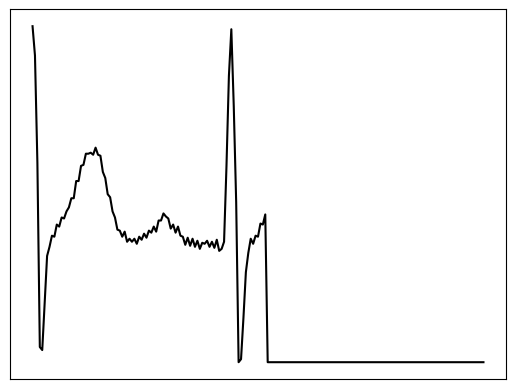

In [4]:
Xtrain.iloc[13].plot(c='k')
plt.xticks([])
plt.yticks([])
plt.savefig('visualize.png')

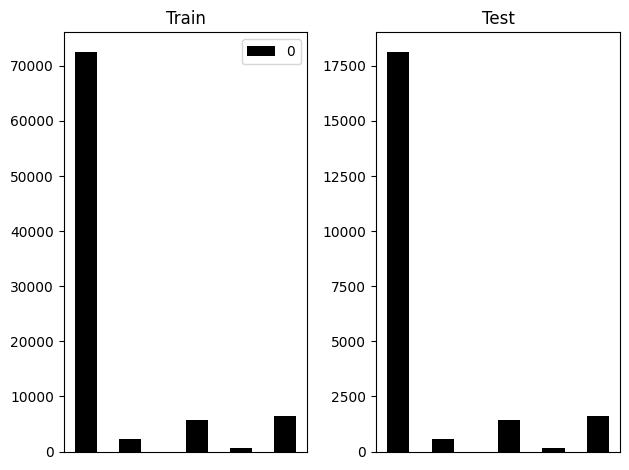

In [5]:
plt.subplot(121)
plt.hist(ytrain, color='k', label=range(5))
plt.xticks([])
plt.legend()
plt.title('Train')

plt.subplot(122)
plt.hist(ytest, color='k')
plt.xticks([])
plt.title('Test')

plt.tight_layout()
plt.savefig('cate-dist')

In [6]:
print(Counter(ytrain))
print(Counter(ytest))

Counter({0: 72471, 4: 6431, 2: 5788, 1: 2223, 3: 641})
Counter({0: 18118, 4: 1608, 2: 1448, 1: 556, 3: 162})


In [7]:
new_train_df = pd.concat((
    train_df[ytrain == 0].sample(7000, random_state=42),
    train_df[ytrain != 0]
))
Xtrain, ytrain = getXy(new_train_df)

oversample = SMOTE()
Xtrain, ytrain = oversample.fit_resample(Xtrain, ytrain)
print(Counter(ytrain))

Counter({0: 7000, 1: 7000, 2: 7000, 3: 7000, 4: 7000})


In [8]:
class ECG(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        return self.X.iloc[idx].values[None, ...], self.y.iloc[idx]

In [9]:
NUM_CPU = cpu_count()
train = ECG(Xtrain, ytrain)
train_loader = DataLoader(train, batch_size=64, shuffle=True, num_workers=NUM_CPU)
test = ECG(Xtest, ytest)
test_loader = DataLoader(test, batch_size=64, shuffle=False, num_workers=NUM_CPU)

In [10]:
class MyCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.extract = nn.Sequential(
            nn.Conv1d(1, 64, 3),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.MaxPool1d(2),

            nn.Conv1d(64, 64, 3),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.MaxPool1d(2),
        )
        self.fc = nn.Sequential(
            nn.Linear(64*45, 1024),
            nn.ReLU(),
            nn.Linear(1024, 1024),
            nn.ReLU(),
            nn.Linear(1024, 5),
        )
    
    def forward(self, x):
        x = self.extract(x)
        x = nn.Flatten()(x)
        x = self.fc(x)
        return x

In [11]:
MyCNN()

MyCNN(
  (extract): Sequential(
    (0): Conv1d(1, 64, kernel_size=(3,), stride=(1,))
    (1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv1d(64, 64, kernel_size=(3,), stride=(1,))
    (5): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc): Sequential(
    (0): Linear(in_features=2880, out_features=1024, bias=True)
    (1): ReLU()
    (2): Linear(in_features=1024, out_features=1024, bias=True)
    (3): ReLU()
    (4): Linear(in_features=1024, out_features=5, bias=True)
  )
)

In [13]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = MyCNN().to(device)
optim_fn = optim.Adam(model.parameters(), lr=0.001)
loss_fn = nn.CrossEntropyLoss().to(device)

n_epochs = 13
for epoch in range(1, n_epochs+1):
    model.train()
    losses = []
    for X, y in tqdm(train_loader, desc=f'Epoch {epoch}: '):
        X = X.float().to(device)
        y = y.to(device)
        
        optim_fn.zero_grad()
        out = model(X)
        loss = loss_fn(out, y)
        
        losses.append(loss)
        loss.backward()
        optim_fn.step()
        
    mean_loss = sum(losses)/len(losses)
    print(f'Train loss: {mean_loss:.5f}')
    torch.save(model.state_dict(), '/kaggle/working/last_model.pt')

Epoch 1: 100%|██████████| 547/547 [00:07<00:00, 71.68it/s]


Train loss: 0.32025


Epoch 2: 100%|██████████| 547/547 [00:07<00:00, 73.12it/s]


Train loss: 0.15191


Epoch 3: 100%|██████████| 547/547 [00:07<00:00, 69.76it/s]


Train loss: 0.10115


Epoch 4: 100%|██████████| 547/547 [00:07<00:00, 71.62it/s]


Train loss: 0.07617


Epoch 5: 100%|██████████| 547/547 [00:07<00:00, 71.01it/s]


Train loss: 0.05945


Epoch 6: 100%|██████████| 547/547 [00:07<00:00, 71.78it/s]


Train loss: 0.04555


Epoch 7: 100%|██████████| 547/547 [00:07<00:00, 70.15it/s]


Train loss: 0.04061


Epoch 8: 100%|██████████| 547/547 [00:07<00:00, 73.02it/s]


Train loss: 0.03514


Epoch 9: 100%|██████████| 547/547 [00:07<00:00, 72.18it/s]


Train loss: 0.03323


Epoch 10: 100%|██████████| 547/547 [00:07<00:00, 71.61it/s]


Train loss: 0.02979


Epoch 11: 100%|██████████| 547/547 [00:07<00:00, 69.75it/s]


Train loss: 0.02362


Epoch 12: 100%|██████████| 547/547 [00:07<00:00, 73.59it/s]


Train loss: 0.02205


Epoch 13: 100%|██████████| 547/547 [00:07<00:00, 72.77it/s]

Train loss: 0.02366


In [14]:
model.eval()
preds = []
for X, y in tqdm(test_loader, desc='Validate: '):
    X = X.float().to(device)
    y = y.to(device)

    with torch.no_grad(): out = model(X)
    pred = torch.argmax(out, dim=1)
    preds += pred.tolist()

Validate: 100%|██████████| 343/343 [00:01<00:00, 272.76it/s]


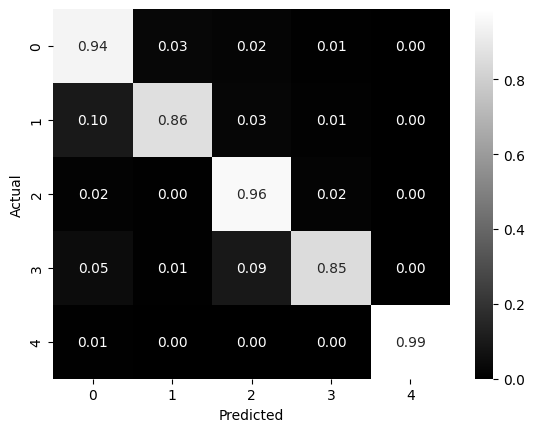

In [19]:
sns.heatmap(
    confusion_matrix(ytest, preds, normalize='true'),
    annot=True, fmt='.2f', cmap='gray'
)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.savefig('confusion')

In [16]:
balanced_accuracy_score(ytest, preds)

0.9208982493594606